# <span style="color:red">Обработка стали</span>

---
**<span style="color: crimson">Заказчик</span>**: ООО «Так закаляем сталь»   
**<span style="color: crimson">Цель анализа</span>**  построить модель (регрессионную), которая предскажет температуру стали для уменьшения потребления электроэнергии на этапе обработки стали.      
**<span style="color: crimson">Целевой признак</span>**: последний замер партии в таблице data_temp (не последний известный, а именно последний).

---

### <span style="color:red">О</span>писание процесса:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

### <span style="color:red">П</span>роцесс обработки:

<img src="https://i.ibb.co/6mJxtXc/diagram-3-removebg-preview.png" width=300/>

### <span style="color:red">T</span>аблицы:

- `data_arc.csv` — данные об электродах, кол-во электроэнергии для плавления стали;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Импорт библиотек:

In [1]:
!pip3 install sidetable
!pip3 install optuna

In [2]:
import pandas as pd
import sidetable as stb
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from lightgbm import LGBMRegressor
from math import sqrt 
from sklearn.metrics import make_scorer, confusion_matrix, mean_absolute_error
from sklearn.utils import shuffle
import optuna

## <span style="color: crimson">Этап 1</span> Предобработка данных

<h3><span style="color: red"><b>| </b></span> Чтение данных</h3>

In [3]:
data_arc = pd.read_csv('./File/data_arc.csv')
data_bulk = pd.read_csv('./File/data_bulk.csv')
data_bulk_time = pd.read_csv('./File/data_bulk_time.csv')
data_gas = pd.read_csv('./File/data_gas.csv')
data_temp = pd.read_csv('./File/data_temp.csv')                       
data_wire = pd.read_csv('./File/data_wire.csv')  
data_wire_time = pd.read_csv('./File/data_wire_time.csv')                       

**Нам нужно подготовить данные для модели:**
1. Оставить только первый и последний (целевой) замер температуры в data_temp (т.к у нас не будет всех циклов производства).
2. Суммировать данные по циклам в партии (эти данные мы можем получить от сотрудников компании еще до отлива стали).

Данные с датами не улучшают модель (при переводе в секунды и масштабировании (дата - минимальная дата)).

---

<h3><span style="color: red"><b>- </b></span> data_arc - данные об электродах;</h3> 

Каждый объект это этап обработки партии, а каждый параметр использованное электричество для разогрева.

**ИЗУЧЕНИЕ АНОМАЛИЙ**

In [4]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


**<span style="color: crimson">Изменить</span>:** названия столбцов (удалить пробелы).

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


**<span style="color: crimson">Изменить</span>:** типы столбцов "Начало нагрева дугой" и "Конец нагрева дугой" на Datetime.

In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


**<span style="color: crimson">Удалить</span>:** значения с отрицательным столбцом "Реактивная мощность". 

**ИСПРАВЛЕНИЕ АНОМАЛИЙ**

In [7]:
data_arc = data_arc.rename(
    columns={
        "Активная мощность": "Активная_мощность",
        "Реактивная мощность": "Реактивная_мощность",
    }
)

In [8]:
data_arc = data_arc.query("Реактивная_мощность > 0")

**ИЗУЧЕНИЕ ДАННЫХ**

Корреляция между активной_мощностью и реактивной_мощностью.

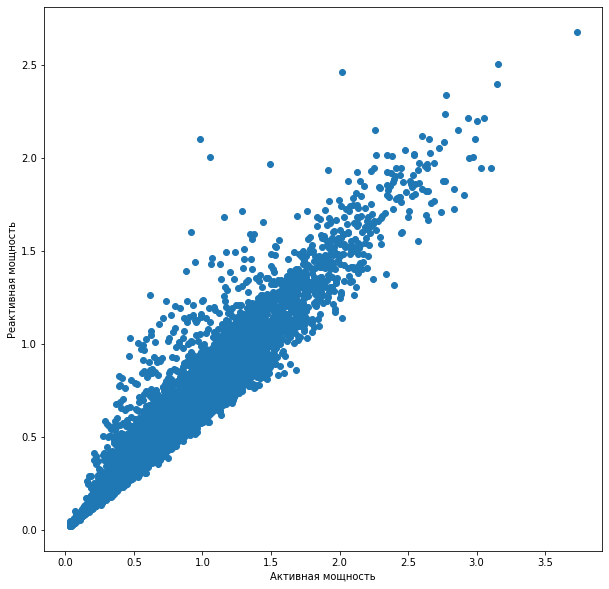

In [9]:
plt.figure(figsize=(10, 10))

plt.scatter(data_arc['Активная_мощность'], data_arc['Реактивная_мощность'])
plt.xlabel("Активная мощность")
plt.ylabel("Реактивная мощность")
plt.show()

**Как видно на графике у наших данных сильная корреляция, так что есть несколько вариантов, чтобы избавится от зависимых данных:**
1. Удалить столбец Активная_мощность
2. Удалить столбец Реактивная_мощность
3. Использовать "полную мощность" $ \sqrt{Активная\_мощность^2 + {Реактивная\_мощность}^2}$
4. Использовать "энергию" ($Полная\_мощность * Время\_работы$) 

Наилучшее качество у **полной мощности** (выяснено экспериментально):

In [10]:
data_arc['Полная_мощность'] = (data_arc['Активная_мощность']**2 + data_arc['Реактивная_мощность']**2).apply(lambda x:sqrt(x))

In [11]:
data_arc = data_arc[['key','Полная_мощность']]

In [12]:
data_arc = data_arc.groupby('key').sum()

---

<h3><span style="color: red"><b>- </b></span> data_bulk - данные о подаче сыпучих материалов (объём);</h3> 

Каждый объект это партия, а каждый параметр добавка (жаль неизвестно какие).

**ИЗУЧЕНИЕ АНОМАЛИЙ**

In [13]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**<span style="color: crimson">Изменить</span>:** названия столбцов (удалить пробелы).

In [14]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [16]:
data_bulk.stb.missing(style=True, clip_0=True)

,missing,total,percent
Bulk 8,"3,128","3,129",99.97%
Bulk 13,"3,111","3,129",99.42%
Bulk 9,"3,110","3,129",99.39%
Bulk 2,"3,107","3,129",99.30%
Bulk 7,"3,104","3,129",99.20%
Bulk 5,"3,052","3,129",97.54%
Bulk 10,"2,953","3,129",94.38%
Bulk 11,"2,952","3,129",94.34%
Bulk 1,"2,877","3,129",91.95%
Bulk 6,"2,553","3,129",81.59%


**<span style="color: crimson">Удалить</span>:** столбцы с кол-ом пропусков больше 80%.

**ИСПРАВЛЕНИЕ АНОМАЛИЙ**

После многочисленных экспериментов такой способ борьбы с пропусками показал наилучшее решение:

In [17]:
data_bulk = data_bulk.dropna(thresh=int(len(data_bulk) * .02), axis=1)

Предположим, что на месте пропусков у нас 0, 

In [18]:
data_bulk = data_bulk.fillna(0)

In [19]:
data_bulk = data_bulk.rename(
    columns={
        "Bulk 1": "Bulk_1",
        "Bulk 3": "Bulk_3",
        "Bulk 4": "Bulk_4",
        "Bulk 5": "Bulk_5",
        "Bulk 6": "Bulk_6",
        "Bulk 10": "Bulk_10",
        "Bulk 11": "Bulk_11",
        "Bulk 12": "Bulk_12",
        "Bulk 14": "Bulk_14",
        "Bulk 15": "Bulk_15"
    }
)

**ИЗУЧЕНИЕ ДАННЫХ**

In [20]:
data_bulk.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,key,Bulk_1,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_10,Bulk_11,Bulk_12,Bulk_14,Bulk_15
key,1.00,-0.06,0.02,-0.07,0.02,-0.01,0.03,0.03,-0.02,-0.09,-0.05
Bulk_1,-0.06,1.00,-0.01,0.05,0.09,0.01,-0.03,-0.04,0.29,0.18,0.00
Bulk_3,0.02,-0.01,1.00,-0.27,-0.00,0.07,-0.09,-0.01,0.01,0.02,0.02
Bulk_4,-0.07,0.05,-0.27,1.00,0.02,-0.23,-0.08,-0.12,0.10,-0.09,0.11
Bulk_5,0.02,0.09,-0.00,0.02,1.00,-0.00,-0.03,-0.02,-0.08,-0.08,-0.07
Bulk_6,-0.01,0.01,0.07,-0.23,-0.00,1.00,-0.09,0.20,-0.14,0.20,-0.10
Bulk_10,0.03,-0.03,-0.09,-0.08,-0.03,-0.09,1.00,-0.04,0.03,-0.05,0.06
Bulk_11,0.03,-0.04,-0.01,-0.12,-0.02,0.20,-0.04,1.00,-0.05,0.07,-0.04
Bulk_12,-0.02,0.29,0.01,0.10,-0.08,-0.14,0.03,-0.05,1.00,0.42,0.59
Bulk_14,-0.09,0.18,0.02,-0.09,-0.08,0.20,-0.05,0.07,0.42,1.00,0.22


Попытка удалить любой параметр (включая те, у которых сильная корреляция) приводит к  уменьшению качества MAE.

---

<h3><span style="color: red"><b>- </b></span> data_gas - данные о продувке сплава газом;</h3>

**ИЗУЧЕНИЕ АНОМАЛИЙ**

In [21]:
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


**<span style="color: crimson">Изменить</span>:** название названий столбцов (удалить пробелы).

**ИСПРАВЛЕНИЕ АНОМАЛИЙ**

In [22]:
data_gas = data_gas.rename(columns={'Газ 1': 'Газ_1'})

---

<h3><span style="color: red"><b>- </b></span> data_temp - результаты измерения температуры;</h3> 

**ИЗУЧЕНИЕ АНОМАЛИЙ**

In [23]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [24]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


**<span style="color: crimson">Удалить</span>:**  столбцец "Время замера" нам не нужен.  
**<span style="color: crimson">Удалить</span>:** партии где меньше двух замеров и/или нет целевой функции.

In [25]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


**ИСПРАВЛЕНИЕ АНОМАЛИЙ**

In [26]:
data_temp = data_temp[['key', 'Температура']]

Оставим только первую и последнюю дату:

In [27]:
last_temp = data_temp.groupby('key').last()
first_temp = data_temp.groupby('key').first()

data_temp = (first_temp).merge(last_temp, on="key", how="inner", suffixes=('_first', '_last'))

Первая и последняя температура не должны быть равны:

In [28]:
data_temp = data_temp.query('Температура_first!=Температура_last')

---

<h3><span style="color: red"><b>- </b></span> data_wire - данные о проволочных материалах (объём);</h3> 

**ИЗУЧЕНИЕ АНОМАЛИЙ**

In [29]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**<span style="color: crimson">Изменить</span>:** названия столбцов (удалить пробелы).

In [30]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [31]:
data_wire.stb.missing(style=True, clip_0=True)

,missing,total,percent
Wire 5,"3,080","3,081",99.97%
Wire 7,"3,070","3,081",99.64%
Wire 4,"3,067","3,081",99.55%
Wire 8,"3,062","3,081",99.38%
Wire 9,"3,052","3,081",99.06%
Wire 3,"3,018","3,081",97.96%
Wire 6,"3,008","3,081",97.63%
Wire 2,"2,002","3,081",64.98%
Wire 1,26,"3,081",0.84%


**<span style="color: crimson">Удалить</span>:** столбцы с кол-ом пропусков больше 80%, а пропуски заменим 0.

**ИСПРАВЛЕНИЕ АНОМАЛИЙ**

In [32]:
data_wire = data_wire.rename(columns={'Wire 1':'Wire_1', 'Wire 2':'Wire_2'})

После многочисленных экспериментов такой способ борьбы с пропусками показал наилучшее решение:

In [33]:
data_wire = data_wire.dropna(thresh=int(len(data_wire) * .1), axis=1)

In [34]:
data_wire = data_wire.fillna(0)

---

<h3><span style="color: red"><b>| </b></span> Склеим датасет в один:</h3>

In [35]:
df = (
    data_arc.merge(data_bulk, on="key", how="inner")
    .merge(data_gas, on="key", how="inner")
    .merge(data_wire, on="key", how="inner")
    .merge(data_temp, on="key", how="inner")
)

Удалим номера партии:

In [36]:
df = df.drop(columns=['key'])

---

## <span style="color: crimson">Этап 2</span>  Создание и тестирование моделей 

#### <span style="color: crimson"> Разделение выборки:

In [37]:
train, valid = train_test_split(df, test_size=0.2, random_state=666)
valid, test = train_test_split(valid, test_size=0.5, random_state=666)


features_train = train.drop(['Температура_last'], axis=1)
target_train = train['Температура_last']

features_test = test.drop(['Температура_last'], axis=1)
target_test = test['Температура_last']

#### <span style="color: crimson"> Настройка optuna:

In [38]:
RANDOM_SEED = 666

kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

#### <span style="color: crimson"> Поиск гиперпараметров:

In [39]:
# %%time

# def LGBM_objective(trial):
#     param_grid = {
#         "num_leaves": trial.suggest_int("num_leaves", 1, 200),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, step=0.01),
#         "max_depth": trial.suggest_int("max_depth", 1, 50),
#         "n_estimators": trial.suggest_int("n_estimators", 10, 500),
#     }

#     LGBM = LGBMRegressor(**param_grid, random_state=RANDOM_SEED)
#     scores = cross_val_score(
#         LGBM, features_train, target_train, cv=kfolds, scoring="neg_mean_absolute_error"
#     )
#     return scores.mean()


# LGBM_params = tune(LGBM_objective)
# LGBM = LGBMRegressor(**LGBM_params, random_state=RANDOM_SEED)

**Тест модели:**

In [40]:
%%time

LGBMR_model = LGBMRegressor(
    num_leaves = 30, learning_rate = 0.2, max_depth = 4, n_estimators = 120).fit(features_train, target_train)
LGBMR_RMSE = mean_absolute_error(target_test, LGBMR_model.predict(features_test))
LGBMR_RMSE

CPU times: total: 531 ms
Wall time: 63.9 ms


5.964166891055178

CPU times: total: 672 ms  
Wall time: 57.8 ms
    
5.964166891055178    

---

## <span style="color: crimson">Этап 3</span>  Общий вывод

**График важности параметров:**

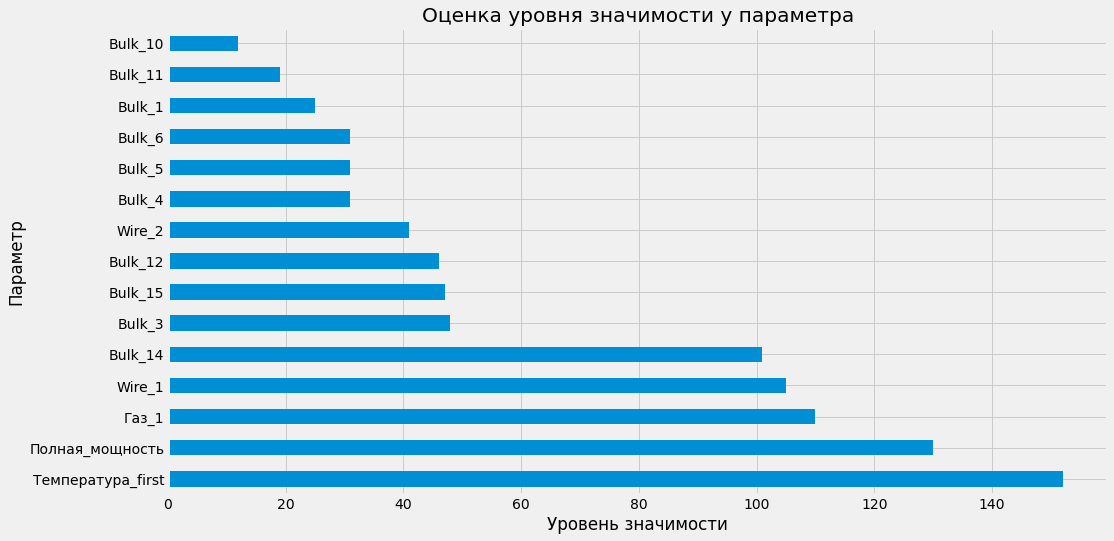

In [41]:
# Стилизация графика
matplotlib.style.use('fivethirtyeight') 

# Размер графика
plt.figure(figsize=(15, 8))

# Название осей и графика
plt.title("Оценка уровня значимости у параметра")
plt.xlabel("Уровень значимости")
plt.ylabel("Параметр")

# Создание графика
feat_importances = pd.Series(LGBMR_model.feature_importances_, index=df.drop(['Температура_last'], axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh');

Лучшее качество **RMAE = 5.9** показывает градиентный бустинг с параметрами:
* num_leaves = 30
* learning_rate = 0.2
* max_depth = 4
* n_estimators = 120